### increase ram size if required

In [ ]:
i = []
while True:
  i.append(i)

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

2.4.1


### get list of top 40 features based on t-test

In [ ]:
ttest_df = pd.read_csv('/content/drive/MyDrive/Thesis/files/unnormalized/t_statistic_array_pre.csv', encoding='latin-1')
ttest_df.ttest_val = np.abs(ttest_df.ttest_val.values)

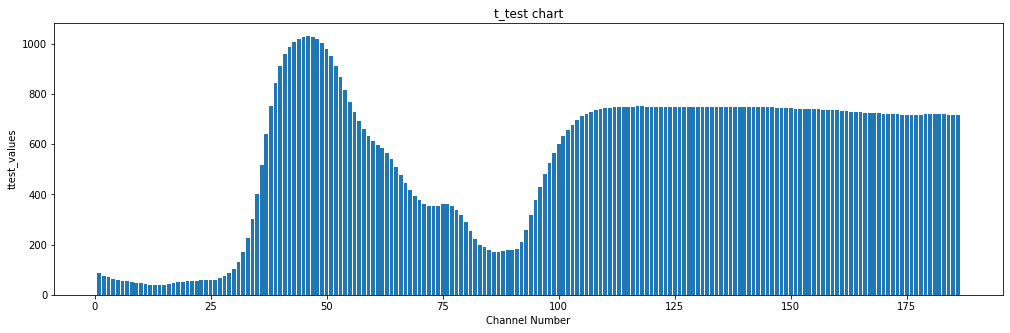

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values)
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
# plt.savefig('/content/drive/MyDrive/Thesis/images/' + '.png')
plt.show() 

In [ ]:
sorted_ttest_df = ttest_df.sort_values(ascending=False, by='ttest_val')

In [ ]:
top_selected = sorted_ttest_df.iloc[:40,:]

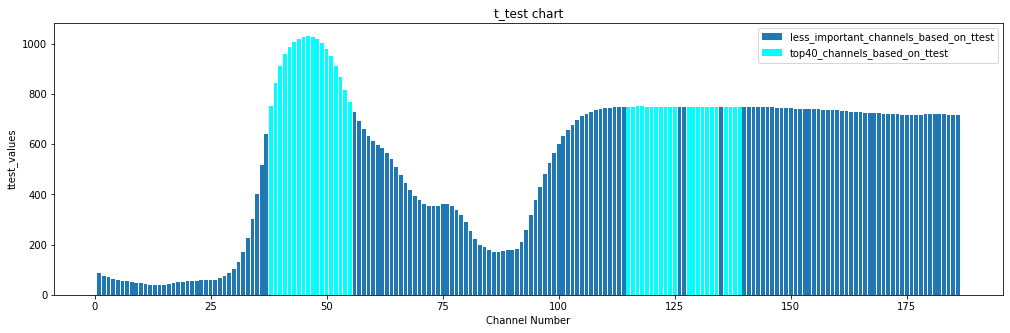

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values, label='less_important_channels_based_on_ttest')
plt.bar(top_selected.band_no.values, top_selected.ttest_val.values, color='cyan', label='top40_channels_based_on_ttest')
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Thesis/images/unnormalized/LR/' + 'top40_ttest_unnormalized' + '.png')
plt.show() 

### load selected channels for training

In [ ]:
# bands_list = top_selected.band_no.values

In [ ]:
# bands_list

array([ 46,  47,  45,  48,  44,  43,  49,  42,  50,  41,  51,  52,  40,
        53,  39,  54,  55,  38, 117, 118, 130, 131, 116, 119, 129, 115,
       132, 137, 138, 124, 123, 120, 133, 128, 122, 134, 136, 139, 121,
       125])

In [ ]:
# y = np.load('/content/drive/MyDrive/Thesis/bands_unnormalized/label.npy').reshape(-1, 1)

In [ ]:
# X = np.zeros((34594800, 40), dtype='float32')

In [ ]:
# for i in range(len(bands_list)):
#   X[:, i:i+1] = np.load('/content/drive/MyDrive/Thesis/bands_unnormalized/band_' + str(bands_list[i]) + '.npy')
#   print(i)

In [ ]:
# using numpy =====================================
# X = np.concatenate((X, y), axis=1)
# np.random.shuffle(X)
# y = X[:, 50:]
# X = np.delete(X, 50, 1)

In [ ]:
df = pd.DataFrame(data=X)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002880,0.002742,0.002643,0.002778,0.002507,0.002450,0.002881,0.002616,0.003010,0.002568,0.003084,0.002944,0.002427,0.002954,0.002463,0.003019,0.003206,0.002395,0.003713,0.003540,0.003705,0.003615,0.003695,0.003746,0.003480,0.003918,0.003543,0.003267,0.003301,0.003767,0.003685,0.003509,0.003300,0.003495,0.003745,0.003422,0.003163,0.003299,0.003701,0.003625
1,0.002811,0.002881,0.002664,0.002777,0.002606,0.002518,0.002921,0.002479,0.002832,0.002581,0.002948,0.002994,0.002504,0.002950,0.002503,0.003016,0.003078,0.002411,0.003871,0.003814,0.003608,0.003456,0.003758,0.003719,0.003583,0.003636,0.003459,0.003253,0.003314,0.003627,0.003859,0.003631,0.003583,0.003612,0.003786,0.003410,0.003639,0.003359,0.003557,0.003633
2,0.002783,0.002697,0.002683,0.002831,0.002660,0.002594,0.002749,0.002626,0.002846,0.002644,0.002980,0.003039,0.002499,0.003092,0.002449,0.003011,0.003077,0.002468,0.003563,0.003793,0.003410,0.003673,0.003546,0.003810,0.003656,0.003558,0.003365,0.003408,0.003462,0.003808,0.003618,0.003593,0.003372,0.003455,0.003543,0.003389,0.003401,0.003279,0.003834,0.003647


In [ ]:
df.insert(0, "label", value=np.array(y, dtype=int), allow_duplicates=True)

In [ ]:
df = df.sample(frac = 1)
df.head(3)

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
985779,1,0.005834,0.005864,0.005952,0.005980,0.005716,0.005713,0.006302,0.005447,0.006192,0.005482,0.006492,0.006664,0.005352,0.006556,0.005125,0.006694,0.006721,0.005179,0.007598,0.007868,0.007599,0.007965,0.008016,0.007876,0.007817,0.007903,0.007814,0.007504,0.007529,0.008169,0.008153,0.008083,0.007590,0.007630,0.008192,0.007682,0.007487,0.007606,0.007889,0.008014
29481454,0,0.005575,0.005702,0.005663,0.005903,0.005545,0.005494,0.005982,0.005368,0.005800,0.005270,0.006008,0.006098,0.005209,0.006319,0.005233,0.006181,0.006298,0.004932,0.007891,0.008041,0.007681,0.007392,0.007946,0.007828,0.007385,0.007909,0.007433,0.007865,0.007170,0.007935,0.007707,0.007700,0.007575,0.007712,0.008008,0.007422,0.007617,0.007560,0.007978,0.008199
9693757,0,0.008921,0.009288,0.008603,0.009568,0.008037,0.007709,0.009487,0.007578,0.009334,0.007201,0.009653,0.009598,0.006687,0.009444,0.006310,0.008985,0.009052,0.005552,0.043750,0.043055,0.042652,0.043065,0.043062,0.043022,0.042283,0.043519,0.042966,0.042697,0.042422,0.042619,0.043460,0.043002,0.043063,0.042459,0.043537,0.042690,0.044024,0.042124,0.043483,0.043575


In [ ]:
# df.to_pickle('/content/drive/MyDrive/Thesis/shuffled_top40/dataset.pkl')

### logistic regression using keras

In [ ]:
# X = df.iloc[:, 1:]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40_unnormalized/dataset.npy', X)

In [ ]:
# y = df.iloc[:, 0:1]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40_unnormalized/label.npy', y)

In [ ]:
y = np.load('/content/drive/MyDrive/Thesis/shuffled_top40_unnormalized/label.npy')

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/shuffled_top40_unnormalized/dataset.npy')

start preparing dataset

In [ ]:
input_shape = [X.shape[1],]
input_shape

[40]

In [ ]:
band_normalizer = preprocessing.Normalization(input_shape=input_shape)

In [ ]:
bands = np.array(X)

In [ ]:
band_normalizer.adapt(bands)

In [ ]:
model = tf.keras.Sequential([
    band_normalizer,
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40)                81        
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 122
Trainable params: 41
Non-trainable params: 81
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)

In [ ]:
%%time
history = model.fit(
    X, y,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 25% of the training data
    validation_split = 0.25,
    callbacks=[callback]
    )

Epoch 1/100
810816/810816 [==============================] - 961s 1ms/step - loss: 0.7194 - accuracy: 0.5598 - val_loss: 0.7612 - val_accuracy: 0.5720
Epoch 2/100
810816/810816 [==============================] - 965s 1ms/step - loss: 0.7201 - accuracy: 0.5600 - val_loss: 0.6644 - val_accuracy: 0.5839
Epoch 3/100
810816/810816 [==============================] - 963s 1ms/step - loss: 0.7198 - accuracy: 0.5601 - val_loss: 0.7129 - val_accuracy: 0.5661
Epoch 4/100
810816/810816 [==============================] - 967s 1ms/step - loss: 0.7198 - accuracy: 0.5599 - val_loss: 0.6839 - val_accuracy: 0.5764
CPU times: user 1h 19min 59s, sys: 11min 39s, total: 1h 31min 38s
Wall time: 1h 4min 16s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.719220,0.560103,0.761222,0.571956,0
1,0.719571,0.560110,0.664442,0.583929,1
2,0.719715,0.560037,0.712933,0.566102,2
3,0.719572,0.559892,0.683911,0.576414,3


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

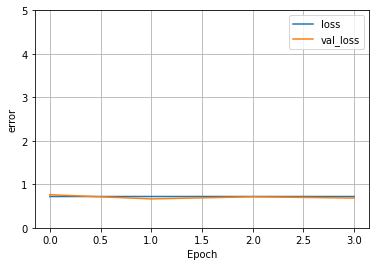

In [ ]:
plot_loss(history)

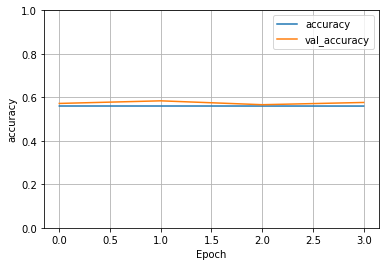

In [ ]:
plot_accuracy(history)

In [ ]:
# predict = model.predict(X)
# accuracy_score(np.round(predict), y[:])

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)